# Problem 2

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
#initialization code required to make tensorflow work on my systemabs
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
# #disabling eager execution 
# tf.compat.v1.disable_eager_execution()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version: ",tf.__version__)
import math
from tensorflow.keras.losses import CategoricalCrossentropy
import pandas as pd 
from tqdm import trange
import matplotlib.pyplot as plt 


Num GPUs Available:  1
Tensorflow version:  2.4.0


### load trained model (without softmax) and test images 

In [2]:
model = keras.models.load_model(r'model')
x_attack_test = np.load(r'x_attack_test.npy')
y_attack_test = np.load(r'y_attack_test.npy')
#make sure it is not trainable 
model.trainable = False


### l2 dist utility

In [3]:
#l2 dist is a utility we will use
def l2_squared(a,b):
    #returns the square of the l2 norm of the given matrices (multiple batches)
    #given matrices must have equal dimension 
    assert a.shape == b.shape
    return tf.reduce_sum(tf.math.square(a - b),axis=[1,2,3])

### General C&W attack framework

In [7]:
class CustomCW:
    ## my custom custom CW attack class: customizable objective function  
    def __init__(self,c,objective,num_iters,learning_rate,verbose=False):
        self.c = c
        self.objective = objective
        self.num_iters = num_iters
        self.lr=learning_rate
        self.verbose = verbose
        
    def delta(self,w):
        #simply applies tanh to the given input multiplies by half and adds 1 and adds 1
        #this is the perturbation 
        out =  0.5*(tf.tanh(w)+1)
        return out
    
    
    def get_loss(self,x,adv_x):
        #x and transformed to tanh space for optimization as per C&W code: this improved my results 
        loss = l2_squared(adv_x,self.delta(x)) + self.c*self.objective.get_obj(adv_x)
        #sum up losses across images 
        return tf.reduce_sum(loss)
        
        
        
    def attack(self,images):
        ##attack the images so they  are misclassified to the target class
        
        #w and orginal images as tensorflow variables 
        w = tf.Variable(np.zeros(images.shape,dtype=np.float32))
        original_images = tf.Variable(images,dtype=np.float32)
        
        optimizer = Adam(self.lr)
        
        #so we can stop training wehen loss stops increasing 
        prev_loss = math.inf
        
        
        for it in trange(self.num_iters):
            with tf.GradientTape() as tape:
                delta = self.delta(w)
                adversarial_images = original_images + delta
                
                loss = self.get_loss(original_images,adversarial_images)
                
                #stop training if loss stops decreasing by 0.1 
                if(abs(prev_loss-loss)<0.1):
                    break
            
            
            #update w using gradients  
            gradients = tape.gradient(loss, [w])
            optimizer.apply_gradients(zip(gradients, [w]))
            
            #printing out progress 
            if(it%100==0 and self.verbose):
                print(f"iteration {it}: loss = {loss}")
                
                
        #return images    
        return adversarial_images
      
            
                
            
            
        
    
    
    

### (1) Szedegy et al objective 

In [8]:
class szedegy:
    #thi class is a function object that applies the loss function from szedegy et al:
    #the objective in question here is simply the cross entropy loss on the target class
    
    def __init__(self, model, target, num_classes):
        #init with model we are attacking and target 
        
        self.model = model
        self.num_classes = num_classes
        
        #transform target to categorical space
        target_cat = [0]*num_classes
        target_cat[target] = 1
        self.target = tf.constant([target_cat])
        
        #loss object: we use categorical cross entropy
        self.loss = CategoricalCrossentropy(from_logits=True)
        
    def get_obj(self,adv_x):
        batch_size = len(adv_x)
        #get logits on adv_x
        logits = self.model(adv_x)
        #simply returns cross entropy loss wrt to target 

        return self.loss(tf.broadcast_to(self.target,[batch_size,self.num_classes]),logits)
        
    
        

### (2) f_6 objective from C&W paper 

In [9]:
class f6:
       
    #this class is a function object that applies f6 loss from the C&W Paper
    def __init__(self,model,target,num_classes):
        self.model = model
        self.target = target 
        self.num_classes = num_classes
        
    def get_max_z_not_t(self,logits):
        #gets the maximum logit thats not the target class 
        return tf.reduce_max(tf.gather(logits,indices = [i for i in list(range(self.num_classes)) if i!=self.target],axis=1),axis=1)
    def get_obj(self,x_adv):
        #returns the f6 objective of the given adversarial image 
        logits = self.model(x_adv)
        return tf.math.maximum(self.get_max_z_not_t(logits)-logits[:,self.target],tf.constant([0.0]))
    
        
        
        
        
     
    
 
        
    

## Problem 2a - adversarial success as a function of c 

In [13]:
#same learning rate as ART to standardize
learning_rate = 0.01
num_iters = 50
constants = constants = [0.5,1,5,10]

target = 7
num_test_samples = len(x_attack_test)
num_classes = 10

### Szedegy objective

In [14]:
#store attack metrics for various c's in a list of dictionaries 
szedegy_attack_metrics = []
for idx,c in enumerate(constants):
    ## Szedegy objective 
    
    print(f"=====attacking at c = {c}=====")
    #generate attack images 
    szedegy_obj = szedegy(model,target,num_classes)
    sz_cw = CustomCW(c,szedegy_obj,num_iters,learning_rate)
    sz_attacks = sz_cw.attack(x_attack_test)
    
    #predictions
    sz_predict = model.predict(sz_attacks)
    
    #calculate success rate
    success_mask = np.argmax(sz_predict, axis=1) == target
    attack_success_rate = sum(success_mask)/num_test_samples
    
   
    #calculate l2 norm 
    l2dist = np.sqrt(np.sum(np.square(x_attack_test - sz_attacks).reshape(num_test_samples, -1), axis=1))
    
    #create series out of l2 dist to pull out min,max,median  
    l2dist = pd.Series(l2dist,index=range(num_test_samples))
                       
                       
    #Report attack success rate and avg l2 norm 
    print(f"Attack Success Rate targeted C&W attack with Szedegy obj at c= {c} : {round(attack_success_rate*100,2)}%")
    print(f"Avg L2 Norm on targeted C&W with Szedegy obj at c = {c} : {round(l2dist.mean(),2)}")
    
    
    
    min_l2_idx = pd.Series.idxmin(l2dist[success_mask])
    max_l2_idx = pd.Series.idxmax(l2dist[success_mask])
    median_l2_idx = int(l2dist[success_mask].sort_values(ignore_index=False).reset_index().iloc[sum(success_mask)//2]['index'])
    
    
    #append the l2 metrics
    szedegy_attack_metrics.append(
    { 
        'c':c,
        'attack_success_rate':attack_success_rate,
        'min_l2_idx':min_l2_idx,
        'max_l2_idx':max_l2_idx,
        'median_l2_idx':median_l2_idx,
        
        'min_l2':l2dist[min_l2_idx],
        'max_l2':l2dist[max_l2_idx],
        'median_l2':l2dist[median_l2_idx],
        
        'original_image_min_l2':x_attack_test[min_l2_idx],
        'original_image_max_l2':x_attack_test[max_l2_idx],
        'original_image_median_l2':x_attack_test[median_l2_idx],
        
        'attack_image_min_l2':sz_attacks[min_l2_idx],
        'attack_image_max_l2':sz_attacks[max_l2_idx],
        'attack_image_median_l2':sz_attacks[median_l2_idx],
        
        'perturbation_min_l2':x_attack_test[min_l2_idx]- sz_attacks[min_l2_idx],
        'perturbation_max_l2':x_attack_test[max_l2_idx] - sz_attacks[max_l2_idx],
        'perturbation_median_l2':x_attack_test[median_l2_idx] - sz_attacks[median_l2_idx]
        
        
        
        
    })
                       
    
                       
    
    
    

=====attacking at c = 0.5=====


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.37it/s]


Attack Success Rate targeted C&W attack with Szedegy obj at c= 0.5 : 35.0%
Avg L2 Norm on targeted C&W with Szedegy obj at c = 0.5 : 13.279999732971191
=====attacking at c = 1=====


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 62.74it/s]


Attack Success Rate targeted C&W attack with Szedegy obj at c= 1 : 56.0%
Avg L2 Norm on targeted C&W with Szedegy obj at c = 1 : 13.350000381469727
=====attacking at c = 5=====


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.69it/s]


Attack Success Rate targeted C&W attack with Szedegy obj at c= 5 : 71.0%
Avg L2 Norm on targeted C&W with Szedegy obj at c = 5 : 13.649999618530273
=====attacking at c = 10=====


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 61.73it/s]

Attack Success Rate targeted C&W attack with Szedegy obj at c= 10 : 71.0%
Avg L2 Norm on targeted C&W with Szedegy obj at c = 10 : 13.800000190734863


In [28]:
szedegy_df = pd.DataFrame(szedegy_attack_metrics)

Text(0, 0.5, 'success rate')

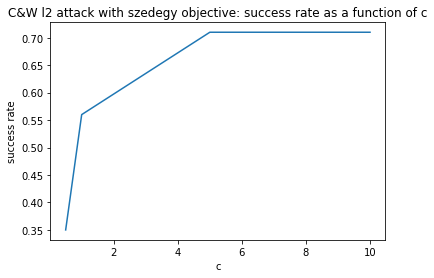

In [29]:
fig = plt.figure()
ax = plt.axes()
ax.plot(szedegy_df['c'], szedegy_df['attack_success_rate'])
plt.title("C&W l2 attack with szedegy objective: success rate as a function of c")
plt.xlabel("c")
plt.ylabel("success rate")

### f_6 objective from C&W paper

In [15]:
#store attack metrics for various c's in a list of dictionaries 
f6_attack_metrics = []
for idx,c in enumerate(constants):
    ## f6 objective 
    
    print(f"=====attacking at c = {c}=====")
    #generate attack images 
    f6_obj = f6(model,target,num_classes)
    #higher learning rates for lower c's
    f6_cw = CustomCW(c,f6_obj,num_iters,learning_rate)
    f6_attacks = f6_cw.attack(x_attack_test)
    
    #predictions
    f6_predict = model.predict(f6_attacks)
    
    #calculate success rate
    success_mask = np.argmax(f6_predict, axis=1) == target
    attack_success_rate = sum(success_mask)/num_test_samples
    
   
    #calculate l2 norm 
    l2dist = np.sqrt(np.sum(np.square(x_attack_test - f6_attacks).reshape(num_test_samples, -1), axis=1))
    #create series out of l2 dist to pull out min,max,median  
    l2dist = pd.Series(l2dist,index=range(num_test_samples))
                       
                       
    #Report attack success rate and avg l2 norm 
    print(f"Attack Success Rate targeted C&W attack with f6 obj at c= {c} : {round(attack_success_rate*100,2)}%")
    print(f"Avg L2 Norm on targeted C&W with f6 obj at c = {c} : {round(l2dist.mean(),2)}")
    
    min_l2_idx = pd.Series.idxmin(l2dist[success_mask])
    max_l2_idx = pd.Series.idxmax(l2dist[success_mask])
    median_l2_idx = int(l2dist[success_mask].sort_values(ignore_index=False).reset_index().iloc[sum(success_mask)//2]['index'])
    
    #append the l2 metrics
    f6_attack_metrics.append(
    { 
        'c':c,
        'attack_success_rate':attack_success_rate,
        'min_l2_idx':min_l2_idx,
        'max_l2_idx':max_l2_idx,
        'median_l2_idx':median_l2_idx,
        
        'min_l2':l2dist[min_l2_idx],
        'max_l2':l2dist[max_l2_idx],
        'median_l2':l2dist[median_l2_idx],
        
        'original_image_min_l2':x_attack_test[min_l2_idx],
        'original_image_max_l2':x_attack_test[max_l2_idx],
        'original_image_median_l2':x_attack_test[median_l2_idx],
        
        'attack_image_min_l2':f6_attacks[min_l2_idx],
        'attack_image_max_l2':f6_attacks[max_l2_idx],
        'attack_image_median_l2':f6_attacks[median_l2_idx],
        
        'perturbation_min_l2':x_attack_test[min_l2_idx]- f6_attacks[min_l2_idx],
        'perturbation_max_l2':x_attack_test[max_l2_idx] - f6_attacks[max_l2_idx],
        'perturbation_median_l2':x_attack_test[median_l2_idx] - f6_attacks[median_l2_idx]
        
        
        
        
    })

=====attacking at c = 0.5=====


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.17it/s]


Attack Success Rate targeted C&W attack with f6 obj at c= 0.5 : 32.0%
Avg L2 Norm on targeted C&W with f6 obj at c = 0.5 : 13.289999961853027
=====attacking at c = 1=====


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.89it/s]


Attack Success Rate targeted C&W attack with f6 obj at c= 1 : 48.0%
Avg L2 Norm on targeted C&W with f6 obj at c = 1 : 13.359999656677246
=====attacking at c = 5=====


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.74it/s]


Attack Success Rate targeted C&W attack with f6 obj at c= 5 : 73.0%
Avg L2 Norm on targeted C&W with f6 obj at c = 5 : 13.680000305175781
=====attacking at c = 10=====


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.17it/s]


Attack Success Rate targeted C&W attack with f6 obj at c= 10 : 75.0%
Avg L2 Norm on targeted C&W with f6 obj at c = 10 : 13.819999694824219


In [30]:
f6_df = pd.DataFrame(f6_attack_metrics)

Text(0, 0.5, 'success rate')

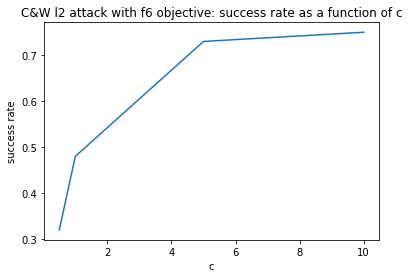

In [31]:
fig = plt.figure()
ax = plt.axes()
ax.plot(f6_df['c'], f6_df['attack_success_rate'])
plt.title("C&W l2 attack with f6 objective: success rate as a function of c")
plt.xlabel("c")
plt.ylabel("success rate")

### Observations
<ol>
    <li> Szegedy objective seems to perform slightly worse than the f_6 objective, but only for the high values of c like 5 and 10. It performs better than f_6 for low values of c </li>
    <li> Both attacks have very similar avg l2 perturbation norms, which dont vary much as per c. 
   

## Problem 2b Min,Max and Median l2 distance images for various values of c: Successful Carlini Wagner attacks


### Szedegy objective 

In [34]:
szedegy_df[['c','attack_success_rate','min_l2_idx','min_l2','max_l2_idx','max_l2','median_l2_idx','median_l2',]]

,c,attack_success_rate,min_l2_idx,min_l2,max_l2_idx,max_l2,median_l2_idx,median_l2
0,0.5,0.35,10,12.843558,50,13.571725,1,13.209056
1,1.0,0.56,51,12.629746,55,13.789464,53,13.385027
2,5.0,0.71,77,13.042408,28,14.113783,82,13.674903
3,10.0,0.71,1,13.203969,28,14.229536,82,13.847279


#### C = 0.5 ###

===========MIN L2 ================


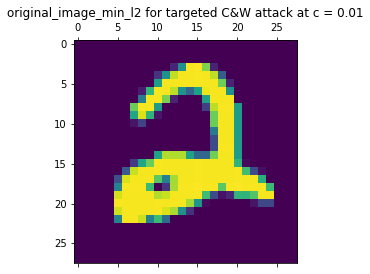

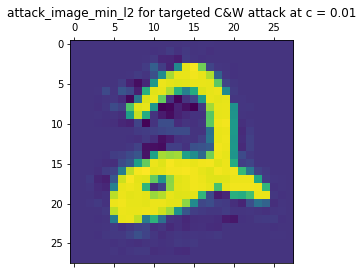

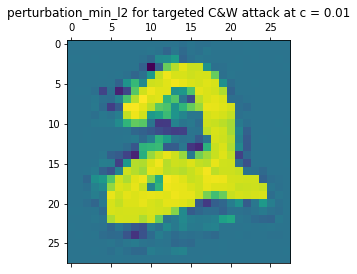

===========MAX L2 ================


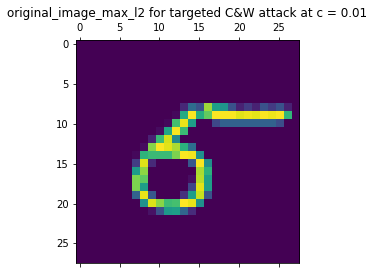

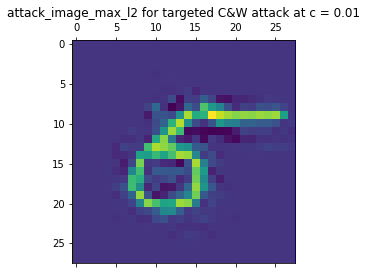

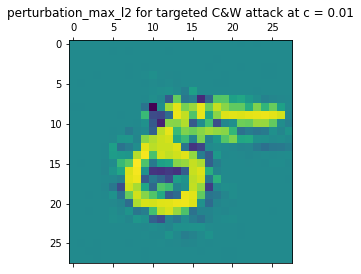

===========MEDIAN L2 ================


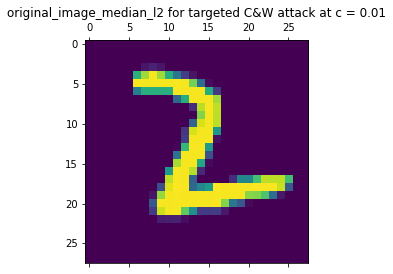

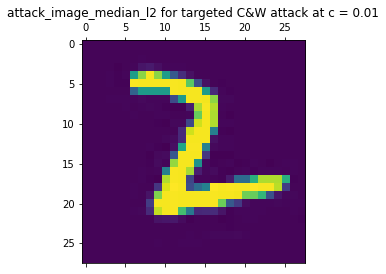

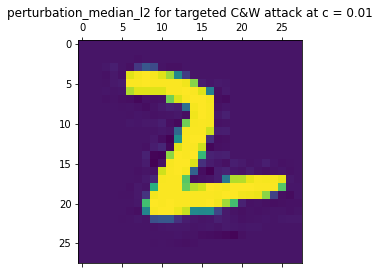

In [16]:
c_i,c = 0,0.01
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()



#### C = 1 ###

===========MIN L2 ================


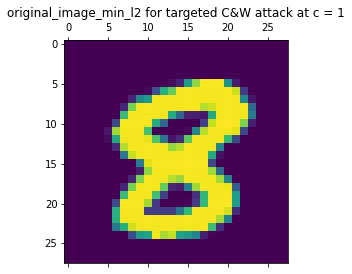

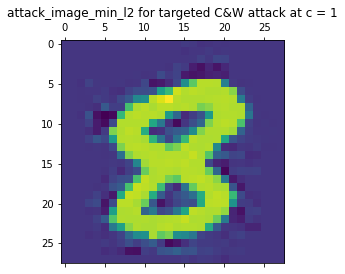

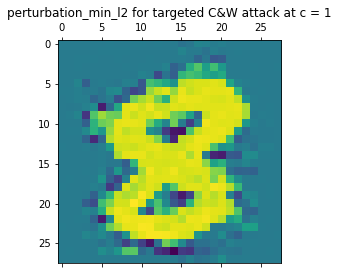

===========MAX L2 ================


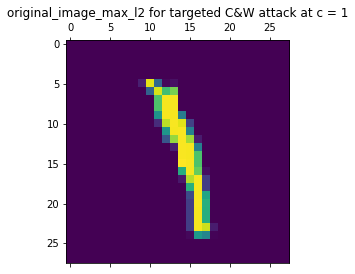

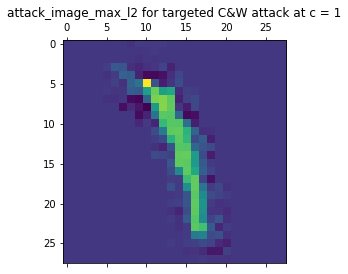

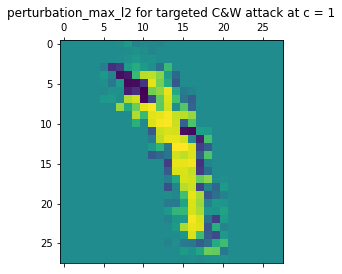

===========MEDIAN L2 ================


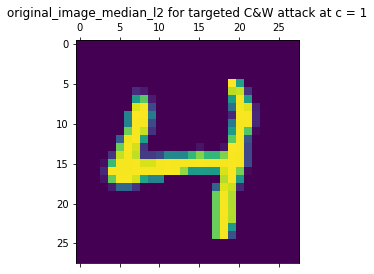

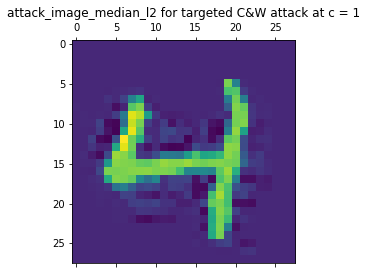

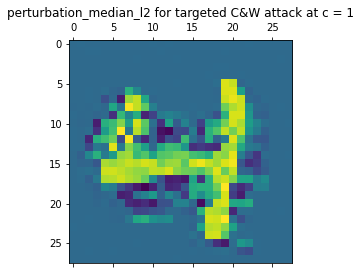

In [18]:
c_i,c = 1,1
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

#### C= 5

===========MIN L2 ================


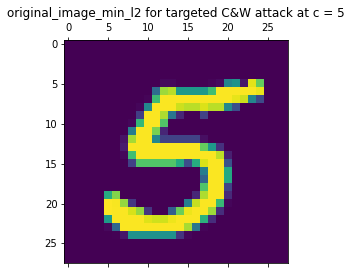

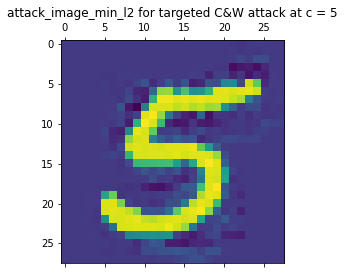

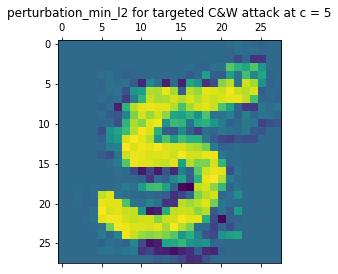

===========MAX L2 ================


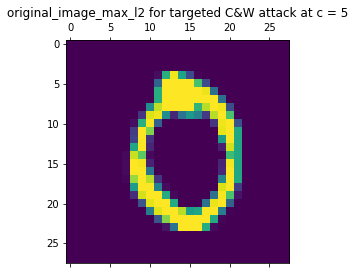

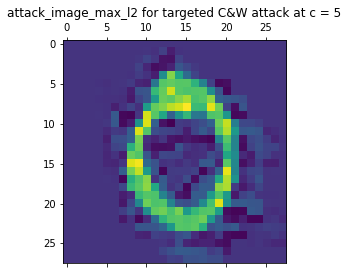

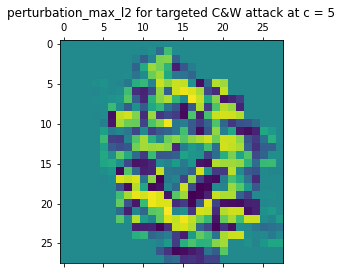

===========MEDIAN L2 ================


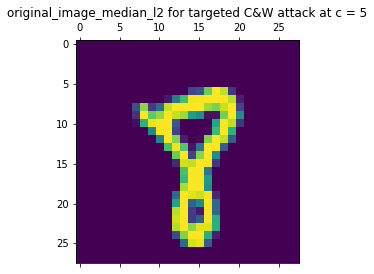

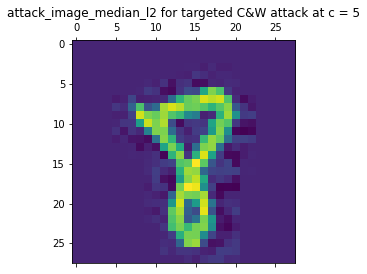

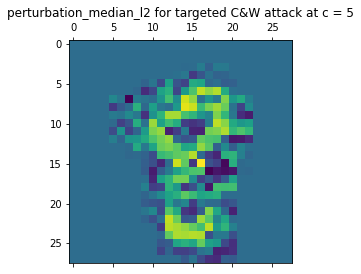

In [19]:
c_i,c = 2,5
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

#### C = 10

===========MIN L2 ================


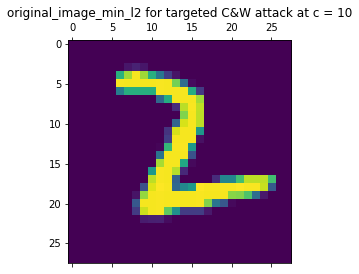

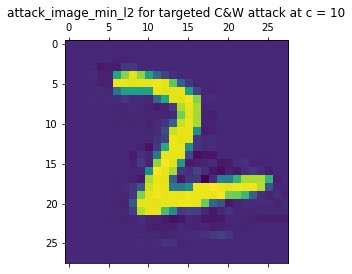

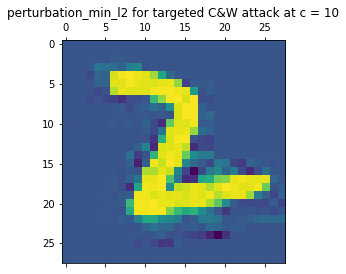

===========MAX L2 ================


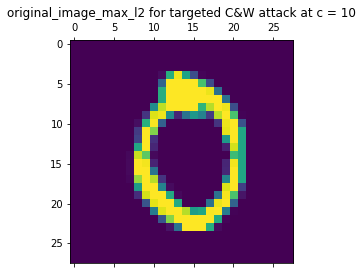

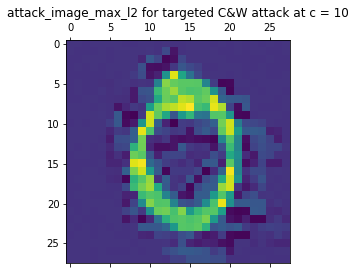

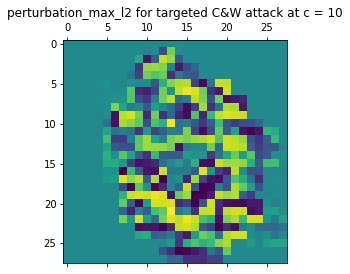

===========MEDIAN L2 ================


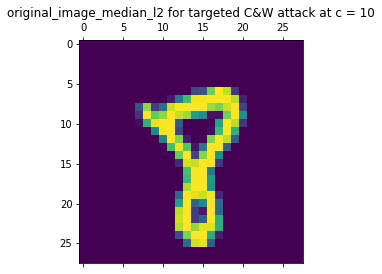

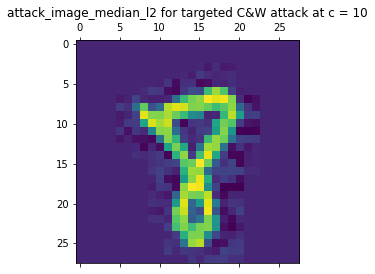

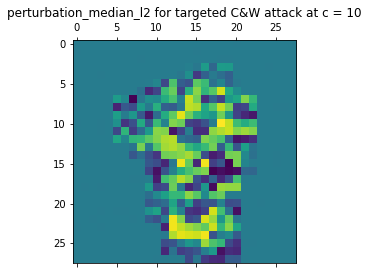

In [20]:
c_i,c = 3,10
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(szedegy_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

### f6 Objective

In [35]:
f6_df[['c','attack_success_rate','min_l2_idx','min_l2','max_l2_idx','max_l2','median_l2_idx','median_l2',]]

,c,attack_success_rate,min_l2_idx,min_l2,max_l2_idx,max_l2,median_l2_idx,median_l2
0,0.5,0.32,8,12.868443,60,13.604152,65,13.360970
1,1.0,0.48,51,12.648972,55,13.793358,53,13.389554
2,5.0,0.73,75,13.034954,28,14.100512,14,13.693420
3,10.0,0.75,75,13.034954,28,14.231073,9,13.847732


#### C = 0.5

===========MIN L2 ================


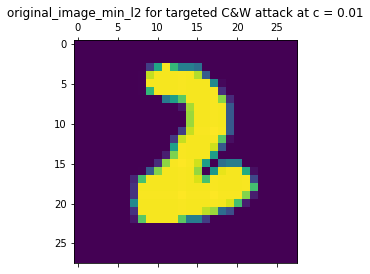

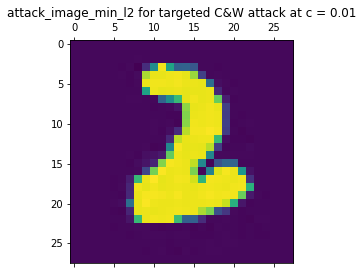

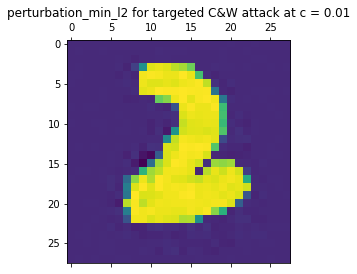

===========MAX L2 ================


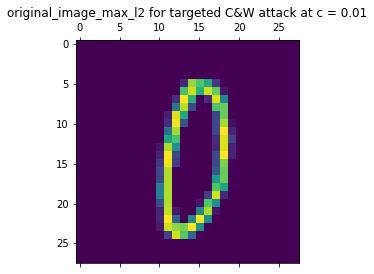

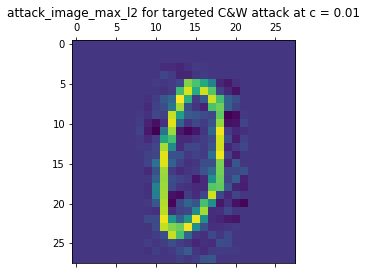

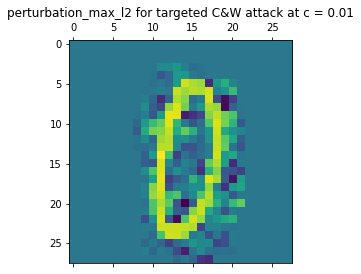

===========MEDIAN L2 ================


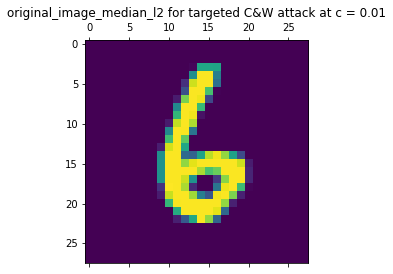

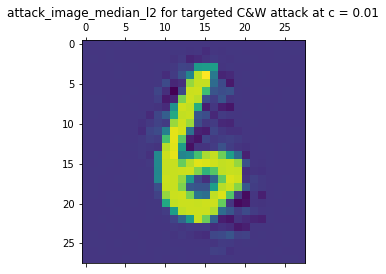

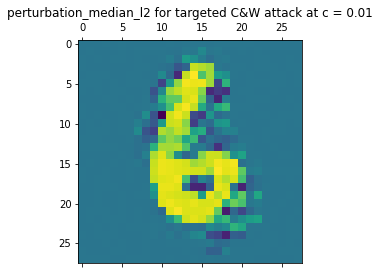

In [22]:
c_i,c = 0,0.01
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()



#### C = 1

===========MIN L2 ================


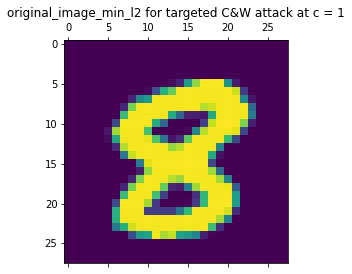

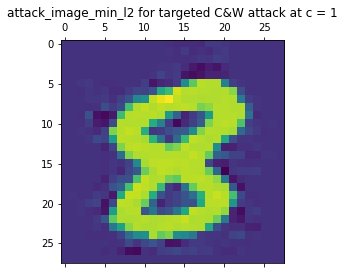

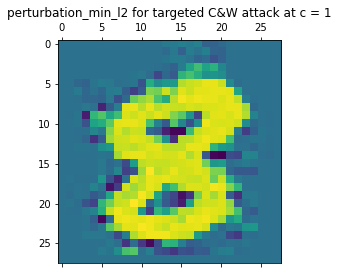

===========MAX L2 ================


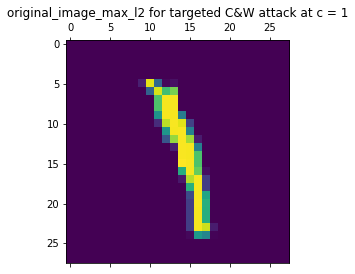

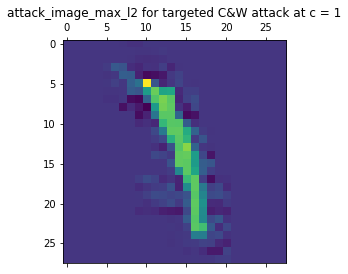

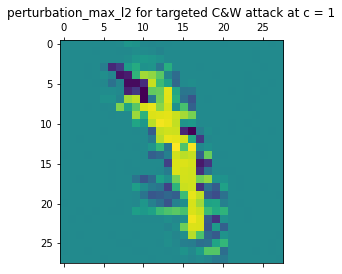

===========MEDIAN L2 ================


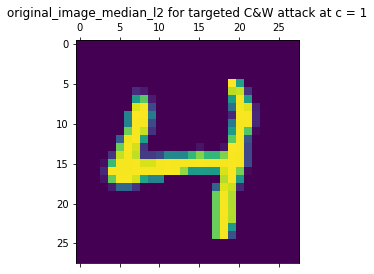

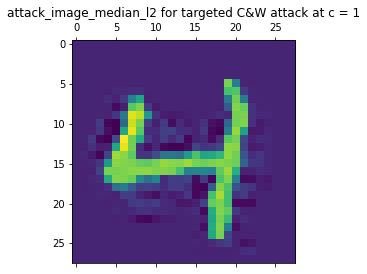

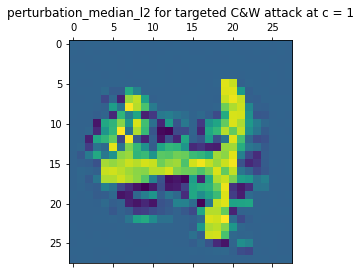

In [23]:
c_i,c = 1,1
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()



#### C = 5

===========MIN L2 ================


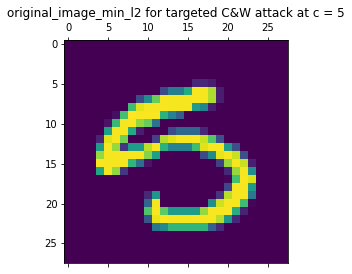

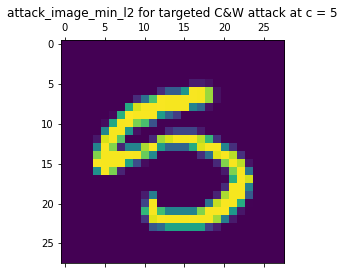

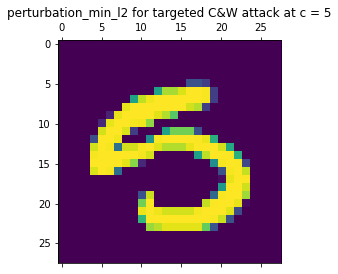

===========MAX L2 ================


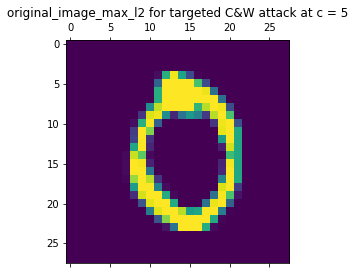

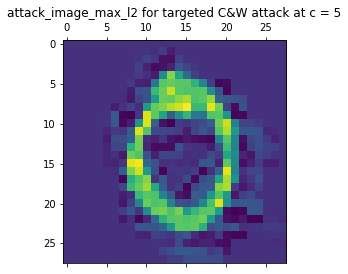

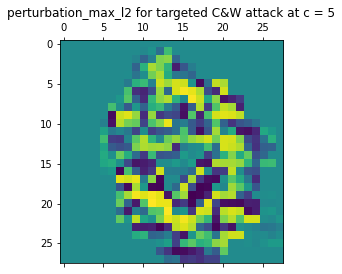

===========MEDIAN L2 ================


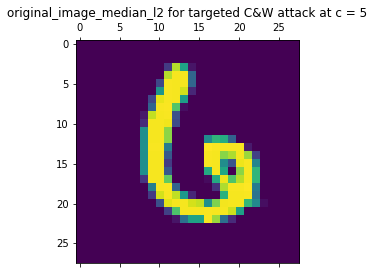

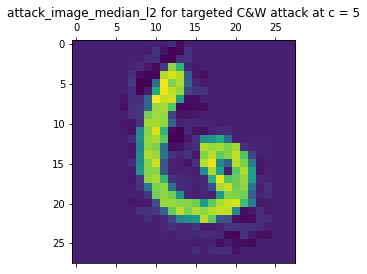

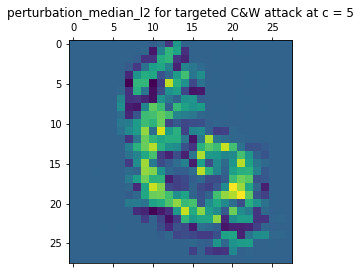

In [24]:
c_i,c = 2,5
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()



#### C = 10

===========MIN L2 ================


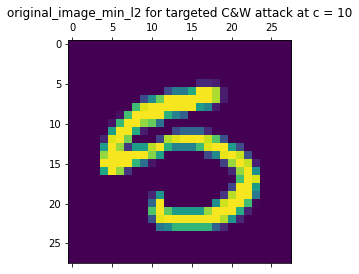

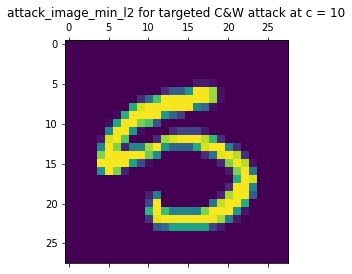

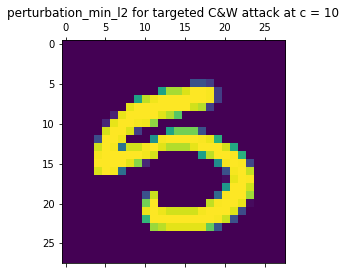

===========MAX L2 ================


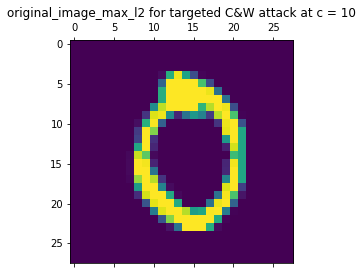

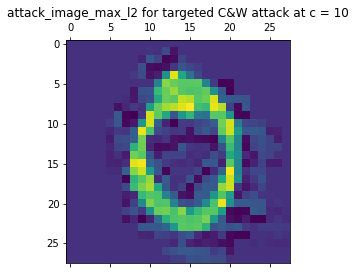

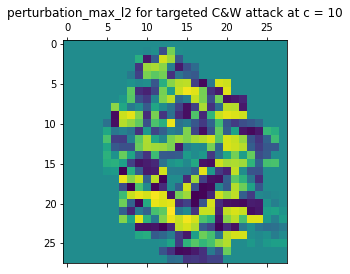

===========MEDIAN L2 ================


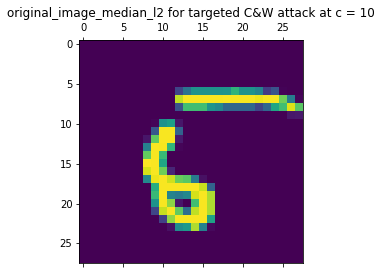

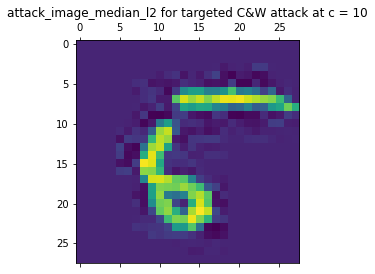

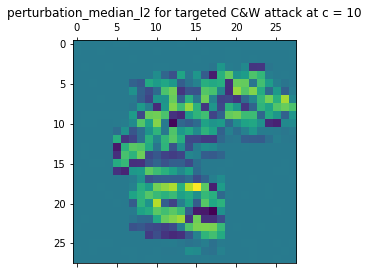

In [25]:
c_i,c = 3,10
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(f6_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()



## 2c: Obsevations

<ol>
    <li> My results were slightly better than the ART library but mostly similar in terms of attack success per per c. The similarity can be explained by the fact that I fixed the learning rate, constant c and number of iterations to the ART library. The differences were more pronounced for smaller values of c like 0.5 and 1</li>
    <li>There was A big difference was the L2 norm. It did not vary as much in my attack (stayed around 12-13). It was also much higher that the ART library, whose L2 norm stayed under 2-3. </li>
    <li> The difference in l2 norm is quiet visible in the images. My attack seems to have much more visible perturbations. </li>